# Alphas, betas and regressions refactoring with classes

Vamos a refectorizar, y veremos porqué lo hacemos con funciones o con clases. Las dos son buenas soluciones pero dependiendo de lo que estamos haciendo nos servirá mejor una cosa u otra. Cada solución responde a una cierta problematica y en particular tenemos que ver qué cosas estamos haciendo de manera que después las debamos utilizar. 

* `funciones` : las utilizo cuando se que estoy haciendo un proceso independiente y que eventualmente voy a reutilizar.
* `clases` : y si cosas que dependen de ciertos procesos particulares prefiero esconderlo con clases porque la encapsulación en mucho más precisa.

Este era el código que teníamos:

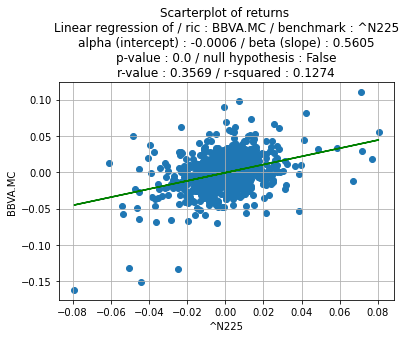

In [6]:
import numpy as np
import pandas as pd
import scipy
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import skew, kurtosis, chi2, linregress
# our own files an reload
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


# BBVA.MC vs Nikkei 225 (^N225)
ric = "BBVA.MC"
benchmark = "^N225"
file_extension = "csv"
nb_decimals = 4

# ric = r_a & benchmark = r_m
x1, str1, t1 = stream_functions.load_time_series(ric)
x2, str2, t2 = stream_functions.load_time_series(benchmark)

# sinchronize timestamps
timestamps1 = list(t1['date'].values) # .values lo convierte en array
timestamps2 = list(t2['date'].values)
timestamps = list(set(timestamps1) & set(timestamps2))

# synchronised time series for x1 (ric)
t1_sync = t1[t1['date'].isin(timestamps)]
t1_sync.sort_values(by='date', ascending=True)
t1_sync = t1_sync.reset_index(drop=True)

# synchronised time series for x2 (benchmark)
t2_sync = t2[t2['date'].isin(timestamps)]
t2_sync.sort_values(by='date', ascending=True)
t2_sync = t2_sync.reset_index(drop=True)

# table of returns for ric and benchmark
t = pd.DataFrame()
t['date'] = t1_sync.date
t['price_1'] = t1_sync.close
t['price_2'] = t2_sync.close
t['return_1'] = t1_sync.return_close
t['return_2'] = t2_sync.return_close

# compute vectors of return
y = t['return_1'].values
x = t['return_2'].values

# linal regression
slope, intercep, r_values, p_values, std_err = linregress(x, y)

slope = np.round(slope, nb_decimals)
intercept = np.round(intercep, nb_decimals)
p_values = np.round(p_values, nb_decimals)
r_values = np.round(r_values, nb_decimals)
r_squared = np.round(r_values**2, nb_decimals)

# Si el `p_value < 0.05` rechazamos la hipótesis nula.
null_hypothesis = p_values > 0.05

# predictor 
predictor_linreg = slope*x + intercept

# scatterplot of returns
str_title = "Scarterplot of returns " + "\n"\
    + "Linear regression of / ric : " + ric\
    + " / benchmark : " + benchmark + "\n"\
    + "alpha (intercept) : " + str(intercept)\
    + " / beta (slope) : " + str(slope) + "\n"\
    + "p-value : " + str(p_values)\
    + " / null hypothesis : " + str(null_hypothesis) + "\n"\
    + "r-value : " + str(r_values)\
    + " / r-squared : " + str(r_squared)

plt.figure()
plt.title(str_title)
plt.scatter(x,y)
plt.plot(x, predictor_linreg, color="green")
plt.ylabel(ric)
plt.xlabel(benchmark)
plt.grid()
plt.show()

Como sincronizar series de tiempo lo voy a utilizar despues para `matriz de varianza y covarianza`, voy a crear una nueva función que voy a llamar **sinchronise_timeseries()**

In [33]:
def synchronise_timeseries(ric, benchmark, file_extension='csv'):
    """Sincroniza series de tiempo.
    Arguments:
        - ric : value
        - benchmark : market
        - file_extension
    Return:
        - x, y para la regresión
        - t para comprobar resultados
        - file_extension
    """
    # loading data from csv o excel from "stream_functions"
    x1, str1, t1 = stream_functions.load_time_series(ric, file_extension)
    x2, str2, t2 = stream_functions.load_time_series(benchmark, file_extension)

    # sinchronize timestamps
    timestamps1 = list(t1['date'].values)
    timestamps2 = list(t2['date'].values)
    timestamps = list(set(timestamps1) & set(timestamps2))

    # synchronised time series for x1 (ric)
    t1_sync = t1[t1['date'].isin(timestamps)]
    t1_sync.sort_values(by='date', ascending=True)
    t1_sync = t1_sync.reset_index(drop=True)

    # synchronised time series for x2 (benchmark)
    t2_sync = t2[t2['date'].isin(timestamps)]
    t2_sync.sort_values(by='date', ascending=True)
    t2_sync = t2_sync.reset_index(drop=True)

    # table of returns for ric and benchmark
    t = pd.DataFrame()
    t['date'] = t1_sync.date
    t['price_1'] = t1_sync.close
    t['price_2'] = t2_sync.close
    t['return_1'] = t1_sync.return_close
    t['return_2'] = t2_sync.return_close

    # compute vectors of return
    y = t['return_1'].values
    x = t['return_2'].values
 
    return x, y, t

He guardado esta función en mi archivo de funciones `stream_functions.py` 

In [35]:
# reset all variables
%reset -f

Ahora tenemos este código más limpio. Ahora lo que me gustaría es poder tener por la mano el `intercept`, el `p_value`, etc y eliminar variables del código. Entonces me voy a crear una clase que me de todas estas variables.

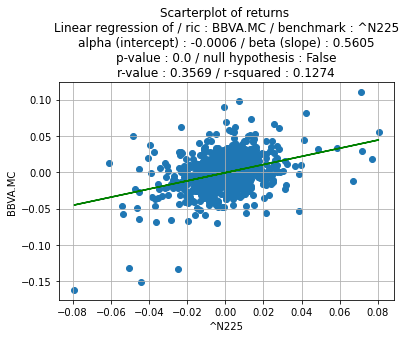

In [36]:
import numpy as np
import pandas as pd
import scipy
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import skew, kurtosis, chi2, linregress
# our own files an reload
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "BBVA.MC"
benchmark = "^N225"
file_extension = "csv"
nb_decimals = 4

# return function
x, y, t = stream_functions.synchronise_timeseries(ric, benchmark)

# linal regression
slope, intercep, r_values, p_values, std_err = linregress(x, y)
slope = np.round(slope, nb_decimals)
intercept = np.round(intercep, nb_decimals)
p_values = np.round(p_values, nb_decimals)
r_values = np.round(r_values, nb_decimals)
r_squared = np.round(r_values**2, nb_decimals)
null_hypothesis = p_values > 0.05
predictor_linreg = slope*x + intercept


# scatterplot of returns
str_title = "Scarterplot of returns " + "\n"\
    + "Linear regression of / ric : " + ric\
    + " / benchmark : " + benchmark + "\n"\
    + "alpha (intercept) : " + str(intercept)\
    + " / beta (slope) : " + str(slope) + "\n"\
    + "p-value : " + str(p_values)\
    + " / null hypothesis : " + str(null_hypothesis) + "\n"\
    + "r-value : " + str(r_values)\
    + " / r-squared : " + str(r_squared)


plt.figure()
plt.title(str_title)
plt.scatter(x,y)
plt.plot(x, predictor_linreg, color="green")
plt.ylabel(ric)
plt.xlabel(benchmark)
plt.grid()
plt.show()

In [24]:
# reset all variables
%reset -f

**Código actual**: 

quiero generar una clase para encapsular más cosas.

Ahora lo que me gustaría es poder tener por la mano el `intercept`, el `p_value`, etc y eliminar variables del código. Entonces me voy a crear una clase que me de todas estas variables.

In [38]:
class capm_manager():
    # constructor
    def __init__(self, ric, benchmark):
        self.nb_decimals = 4
        self.ric = ric
        self.benchmark = benchmark
        self.x = []
        self.y = []
        self.t = pd.DataFrame()
        self.beta = 0.0
        self.alpha = 0.0
        self.p_values = 0.0
        self.null_hypothesis = False
        self.r_values = 0.0
        self.r_squared = 0.0
        self.predictor_linreg = []
    
    def load_timeseries(self):
        """La podría poner dentro de def compute() pero
        de esta forma cada linea de llamada hará una cosa diferente.
        Sincronizar series de tiempo, no es lo mismo que calcular.
        """
        # load timeseries and syncronise them
        self.x, self.y, self.t = stream_functions.synchronise_timeseries(self.ric, self.benchmark)
    
    def compute(self):
        # linal regression of ric with respect to becnhmark
        slope, intercep, r_values, p_values, std_err = linregress(self.x, self.y)
        self.beta = np.round(slope, self.nb_decimals)
        self.alpha = np.round(intercep, self.nb_decimals)
        self.p_values = np.round(p_values, self.nb_decimals)
        self.null_hypothesis = p_values > 0.05
        self.r_values = np.round(r_values, self.nb_decimals)
        self.r_squared = np.round(r_values**2, self.nb_decimals)
        self.predictor_linreg = self.alpha + self.beta*self.x    

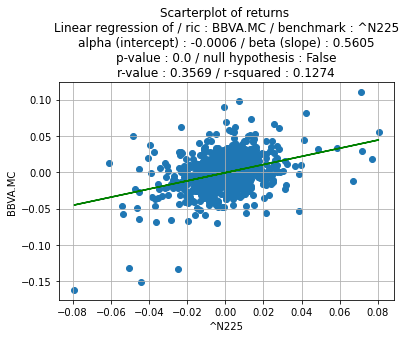

In [39]:
import numpy as np
import pandas as pd
import scipy
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import skew, kurtosis, chi2, linregress
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "BBVA.MC"
benchmark = "^N225"
file_extension = "csv"
nb_decimals = 4

# return function
x, y, t = stream_functions.synchronise_timeseries(ric, benchmark, file_extension)

# class lineal regression
capm = capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()

# scatterplot of returns
str_title = "Scarterplot of returns " + "\n"\
    + "Linear regression of / ric : " + ric\
    + " / benchmark : " + benchmark + "\n"\
    + "alpha (intercept) : " + str(capm.alpha)\
    + " / beta (slope) : " + str(capm.beta) + "\n"\
    + "p-value : " + str(capm.p_values)\
    + " / null hypothesis : " + str(capm.null_hypothesis) + "\n"\
    + "r-value : " + str(capm.r_values)\
    + " / r-squared : " + str(capm.r_squared)

plt.figure()
plt.title(str_title)
plt.scatter(x,y)
plt.plot(x, capm.predictor_linreg, color="green")
plt.ylabel(ric)
plt.xlabel(benchmark)
plt.grid()
plt.show()

In [42]:
# reset all variables
%reset -f

Voy a crear el método `scatterplot`:

In [67]:
import scipy
import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2, linregress


class capm_manager():
    # constructor
    def __init__(self, ric, benchmark):
        self.nb_decimals = 4
        self.ric = ric
        self.benchmark = benchmark
        self.x = []
        self.y = []
        self.t = pd.DataFrame()
        self.beta = 0.0
        self.alpha = 0.0
        self.p_values = 0.0
        self.null_hypothesis = False
        self.r_values = 0.0
        self.r_squared = 0.0
        self.predictor_linreg = []
    
    def load_timeseries(self):
        # load timeseries and syncronise them
        self.x, self.y, self.t = stream_functions.synchronise_timeseries(self.ric, self.benchmark)
    
    def compute(self):
        # linal regression of ric with respect to becnhmark
        slope, intercep, r_values, p_values, std_err = linregress(self.x, self.y)
        self.beta = np.round(slope, self.nb_decimals)
        self.alpha = np.round(intercep, self.nb_decimals)
        self.p_values = np.round(p_values, self.nb_decimals)
        self.null_hypothesis = p_values > 0.05
        self.r_values = np.round(r_values, self.nb_decimals)
        self.r_squared = np.round(r_values**2, self.nb_decimals)
        self.predictor_linreg = self.alpha + self.beta*self.x
    
    def scatterplot(self):
        # scatterplot of returns
        str_title = "Scarterplot of returns " + "\n"\
            + "Linear regression of / ric : " + self.ric\
            + " / benchmark : " + self.benchmark + "\n"\
            + "alpha (intercept) : " + str(self.alpha)\
            + " / beta (slope) : " + str(self.beta) + "\n"\
            + "p-value : " + str(self.p_values)\
            + " / null hypothesis : " + str(self.null_hypothesis) + "\n"\
            + "r-value : " + str(self.r_values)\
            + " / r-squared : " + str(self.r_squared)

        plt.figure()
        plt.title(str_title)
        plt.scatter(self.x,self.y)
        plt.plot(self.x, self.predictor_linreg, color="green")
        plt.ylabel(self.ric)
        plt.xlabel(self.benchmark)
        plt.grid()
        plt.show()

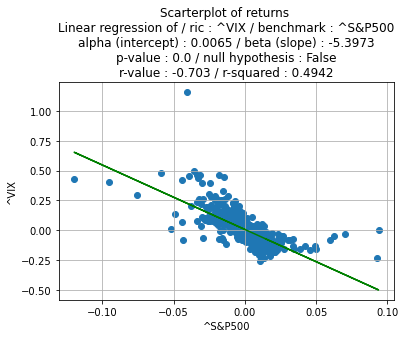

In [68]:
import importlib
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "^VIX"
benchmark = "^S&P500"

# return function
x, y, t = stream_functions.synchronise_timeseries(ric, benchmark)

# class lineal regression
capm = capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()
capm.scatterplot()

Todas mis variables ahora están encapsuladas en `capm`. Aún así, podemos mejorar el código haciéndolo más limpio, para ello podemos introducir la función de carga de series de tiempo en la clase `capm_manager()`

In [55]:
capm.alpha

0.0065

In [56]:
capm.beta

-5.3973

In [91]:
# reset all variables
%reset -f

Voy a crear mi string de salida para la class capm_manager(): 

* `print(capm)` va a lanzar la función `_str_` de la clase `capm_manager` y me va a regresar el string `str_self`"

In [99]:
import scipy
import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2, linregress


class capm_manager():
    # constructor
    def __init__(self, ric, benchmark):
        self.nb_decimals = 4
        self.ric = ric
        self.benchmark = benchmark
        self.x = []
        self.y = []
        self.t = pd.DataFrame()
        self.beta = 0.0
        self.alpha = 0.0
        self.p_values = 0.0
        self.null_hypothesis = False
        self.r_values = 0.0
        self.r_squared = 0.0
        self.predictor_linreg = []
    
    def __str__(self):
        str_self = "Linear regression of | ric : " + self.ric\
            + " | benchmark : " + self.benchmark + "\n"\
            + "alpha (intercept) : " + str(self.alpha)\
            + " | beta (slope) : " + str(self.beta) + "\n"\
            + "p-value : " + str(self.p_values)\
            + " | null hypothesis : " + str(self.null_hypothesis) + "\n"\
            + "r-value : " + str(self.r_values)\
            + " | r-squared : " + str(self.r_squared)
        return str_self
    
    def load_timeseries(self):
        # load timeseries and syncronise them
        self.x, self.y, self.t = stream_functions.synchronise_timeseries(self.ric, self.benchmark)
    
    def compute(self):
        # linal regression of ric with respect to becnhmark
        slope, intercep, r_values, p_values, std_err = linregress(self.x, self.y)
        self.beta = np.round(slope, self.nb_decimals)
        self.alpha = np.round(intercep, self.nb_decimals)
        self.p_values = np.round(p_values, self.nb_decimals)
        self.null_hypothesis = p_values > 0.05
        self.r_values = np.round(r_values, self.nb_decimals)
        self.r_squared = np.round(r_values**2, self.nb_decimals)
        self.predictor_linreg = self.alpha + self.beta*self.x
    
    def scatterplot(self):
        # scatterplot of returns
        str_title = "Scarterplot of returns " + self.__str__()
        plt.figure()
        plt.title(str_title)
        plt.scatter(self.x,self.y)
        plt.plot(self.x, self.predictor_linreg, color="green")
        plt.ylabel(self.ric)
        plt.xlabel(self.benchmark)
        plt.grid()
        plt.show()

In [100]:
import importlib
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "^VIX"
benchmark = "^S&P500"

# class lineal regression
capm = capm_manager(ric, benchmark)
capm.load_timeseries()

Si llamo al str de la clase `capm_manager()` sin realizar el `compute` , sólo tengo el string vacío

**LLAMADAS AL \__str\__ SIN COMPUTOS**

In [101]:
print(capm)

Linear regression of | ric : ^VIX | benchmark : ^S&P500
alpha (intercept) : 0.0 | beta (slope) : 0.0
p-value : 0.0 | null hypothesis : False
r-value : 0.0 | r-squared : 0.0


In [102]:
# print(capm) == capm.__str__()
print(capm.__str__())

Linear regression of | ric : ^VIX | benchmark : ^S&P500
alpha (intercept) : 0.0 | beta (slope) : 0.0
p-value : 0.0 | null hypothesis : False
r-value : 0.0 | r-squared : 0.0


**LLAMADA AL \__str\__ LLAMANDO ANTES AL MÉTODO .COMPUTO**

In [105]:
# class lineal regression
capm = capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()
print(capm)

Linear regression of | ric : ^VIX | benchmark : ^S&P500
alpha (intercept) : 0.0065 | beta (slope) : -5.3973
p-value : 0.0 | null hypothesis : False
r-value : -0.703 | r-squared : 0.4942


In [106]:
# reset all variables
%reset -f

**`stream_classes.py`**
>
> Cargo la clase `capm_manager()` en el archivo **`stream_classes.py`**

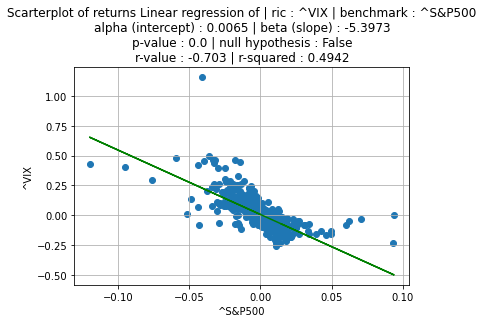

In [132]:
import importlib
import stream_classes
import stream_functions
import stream_04_classes_refactoring2
importlib.reload(stream_classes)
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "^VIX"
benchmark = "^S&P500"

# class lineal regression
capm = stream_classes.capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()
capm.scatterplot()

**VOY A MODIFICAR MI CLASE Jarque-Bera en `stream_classes.py`**  
> La idea es pensar en el programador usuario que va a utilizar el código pero sin saber cómo se construye cada clase. Simplemente sabrá para qué se usa cada clase y la ejecutaré de forma limpia. Para ello será más cómodo que escondamos la función de caraga de datos de series de tiempo y esas variables sea utilizadas dentro de la clase.

Original:

In [ ]:
class jarque_bera_test():

    def __init__(self, x, x_str):
        # create constructor
        self.returns = x
        self.str_name = x_str
        self.size = len(x)  # size of returns
        self.round_digit = 5  # por si quiero modificarlo
        self.mean = 0.0
        self.stdev = 0.0
        self.skew = 0.0
        self.kurt = 0.0
        self.sharpe = 0.0
        self.median = 0.0
        self.var_95 = 0.0
        self.cvar_95 = 0.0
        self.jarque_bera = 0.0
        self.p_value = 0.0
        self.is_normal = 0.0

    def compute(self):
        # compute "risk metrics"
        self.mean = np.mean(self.returns)
        self.stdev = np.std(self.returns)
        self.skew = skew(self.returns)
        self.kurt = kurtosis(self.returns)
        self.sharpe = self.mean / self.stdev * np.sqrt(252)
        self.median = np.median(self.returns)
        self.var_95 = np.percentile(self.returns, 5)
        self.cvar_95 = np.mean(self.returns[self.returns <= self.var_95])
        self.jarque_bera = self.size/6 * (
            self.skew**2 + 1/4*(self.kurt**2)
        )
        self.p_value = 1 - chi2.cdf(self.jarque_bera, df=2)
        self.is_normal = (self.p_value > 0.05)  # equivalenty jb < 6

    def __str__(self):
        str_self = self.str_name + " | size " + str(self.size) + \
                   "\n" + self.plot_str() + "\n"
        return str_self

    def plot_str(self):
        plot_str = "mean: " + str(np.round(self.mean, self.round_digit))\
            + " | std : " + str(np.round(self.stdev, self.round_digit))\
            + " | skewness : " + str(np.round(self.skew, self.round_digit))\
            + " | kurtosis : " + str(np.round(self.kurt, self.round_digit))\
            + " | median : " + str(np.round(self.median, self.round_digit))\
            + " | x_sharpe ratio :" + str(np.round(self.sharpe, 4)) + "\n"\
            + " VaR 95% : " + str(np.round(self.var_95, 4))\
            + " | CVaR 95% : " + str(np.round(self.cvar_95, self.round_digit))\
            + " | Jarque-Bera : " + str(np.round(self.jarque_bera, self.round_digit))\
            + " | p_value : " + str(np.round(self.p_value, self.round_digit))\
            + " | is normal :" + str(self.is_normal)
        return plot_str

> Modificación:
>
> Voy a introducir un método nuevo en la clase que me carga los datos de la serie de tiempo. Así cuando llamo al \__main\__ no hace falta llamar a la función `stream.load_tiem series(ric)`, esta carga quedará encapsulada.

In [110]:
class jarque_bera_test():

    def __init__(self, ric):
        # create constructor
        self.ric = ric
        self.returns = []
        self.size = 0
        self.str_name = None
        self.mean = 0.0
        self.stdev = 0.0
        self.skew = 0.0
        self.kurt = 0.0
        self.sharpe = 0.0
        self.median = 0.0
        self.var_95 = 0.0
        self.cvar_95 = 0.0
        self.jarque_bera = 0.0
        self.p_value = 0.0
        self.is_normal = 0.0

    def load_timeseries(self):
        self.returns, self.str_name, self.t = stream_functions.load_timeseries(self.ric)
        self.size = self.t.shape[0]
    
    def compute(self):
        # compute "risk metrics"
        self.size = self.t.shape[0]
        self.mean = np.mean(self.returns)
        self.stdev = np.std(self.returns)
        self.skew = skew(self.returns)
        self.kurt = kurtosis(self.returns)
        self.sharpe = self.mean / self.stdev * np.sqrt(252)
        self.median = np.median(self.returns)
        self.var_95 = np.percentile(self.returns, 5)
        self.cvar_95 = np.mean(self.returns[self.returns <= self.var_95])
        self.jarque_bera = self.size/6 * (
            self.skew**2 + 1/4*(self.kurt**2)
        )
        self.p_value = 1 - chi2.cdf(self.jarque_bera, df=2)
        self.is_normal = (self.p_value > 0.05)  # equivalenty jb < 6

    def __str__(self):
        str_self = self.str_name + " | size " + str(self.size) + \
                   "\n" + self.plot_str() + "\n"
        return str_self

    def plot_str(self):
        plot_str = "mean: " + str(np.round(self.mean, self.round_digit))\
            + " | std : " + str(np.round(self.stdev, self.round_digit))\
            + " | skewness : " + str(np.round(self.skew, self.round_digit))\
            + " | kurtosis : " + str(np.round(self.kurt, self.round_digit))\
            + " | median : " + str(np.round(self.median, self.round_digit))\
            + " | x_sharpe ratio :" + str(np.round(self.sharpe, 4)) + "\n"\
            + " VaR 95% : " + str(np.round(self.var_95, 4))\
            + " | CVaR 95% : " + str(np.round(self.cvar_95, self.round_digit))\
            + " | Jarque-Bera : " + str(np.round(self.jarque_bera, self.round_digit))\
            + " | p_value : " + str(np.round(self.p_value, self.round_digit))\
            + " | is normal :" + str(self.is_normal)
        return plot_str

> Entonces el usuario realizará sólo estas llamdas de forma sencilla:

Real returns ^VIX | size 1257
mean: 0.0044 | std : 0.0937 | skewness : 2.7739 | kurtosis : 22.2568 | median : -0.0063 | x_sharpe ratio :0.7521
 VaR 95% : -0.1098 | CVaR 95% : -0.1496 | Jarque-Bera : 27556.7893 | p_value : 0.0 | is normal :False



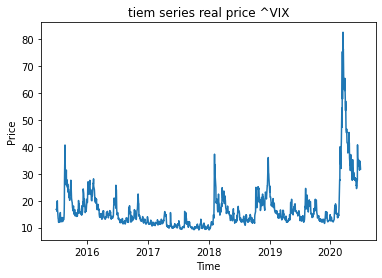

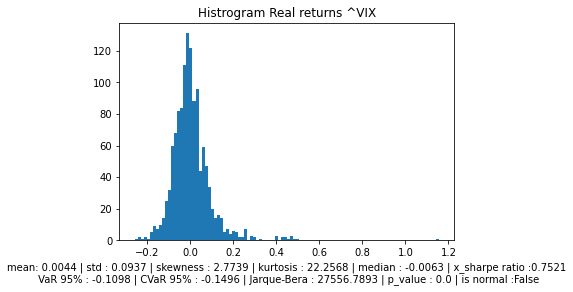

In [123]:
import importlib
import stream_classes
import stream_functions
importlib.reload(stream_classes)
importlib.reload(stream_functions)

ric = "^VIX"

jb = stream_classes.jarque_bera_test(ric)
jb.load_timeseries()
jb.compute()
print(jb)

stream_functions.plot_time_series_price(jb.ric, jb.t)
stream_functions.plot_histogram(jb.returns, jb.str_name, jb.plot_str())

37:07